In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
data = pd.read_excel('/content/drive/MyDrive/holiday packages prediction/Travel.xlsx')
df = data.copy()
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [ ]:
# Mengubah fe male menjadi female
df['Gender'] = df['Gender'].astype('category')
df['Gender'] = df['Gender'].cat.rename_categories({'Fe Male': 'female'})
df['Gender'] = df['Gender'].str.lower()
df['Gender'].value_counts()

male      2916
female    1972
Name: Gender, dtype: int64

In [ ]:
# Mengelompokkan unmarried dan single ke dalam kategori single
df['MaritalStatus'] = df['MaritalStatus'].replace(['Unmarried'], 'Single')
df['MaritalStatus'].value_counts()

Married     2340
Single      1598
Divorced     950
Name: MaritalStatus, dtype: int64

In [ ]:
# Membuang fitur yang tidak digunakan
df.drop(columns=['CustomerID', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting', 'PreferredPropertyStar', 'PitchSatisfactionScore', 'NumberOfChildrenVisiting', 'Designation'],inplace = True)

In [ ]:
# Melihat kolom-kolom yang masih mempunyai missing values
df.isna().sum()

ProdTaken              0
Age                  226
TypeofContact         25
CityTier               0
Occupation             0
NumberOfFollowups     45
ProductPitched         0
MaritalStatus          0
NumberOfTrips        140
Passport               0
OwnCar                 0
MonthlyIncome        233
dtype: int64

In [ ]:
# Melihat kolom-kolom yang masih mempunyai missing values dalam persen
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

ProdTaken            0.000000
Age                  4.623568
TypeofContact        0.511457
CityTier             0.000000
Occupation           0.000000
NumberOfFollowups    0.920622
ProductPitched       0.000000
MaritalStatus        0.000000
NumberOfTrips        2.864157
Passport             0.000000
OwnCar               0.000000
MonthlyIncome        4.766776
dtype: float64

In [ ]:
# Menghapus kolom 'TypeofContact' dan 'NumberOfFollowups'
df = df.dropna(subset=['TypeofContact','NumberOfFollowups'])

In [ ]:
# Mengisi missing values pada kolom 'Age' dengan mean karena distribusinya mendekati normal, dan mengisi nilai median untuk kolom 'MonthlyIncome' karena skew positif
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)

In [ ]:
# Mengisi missing values pada kolom 'NumberOfTrips' dengan nilai modus yaitu 2
df['NumberOfTrips'].fillna(df['NumberOfTrips'].mode()[0], inplace=True)

In [ ]:
# Memeriksa apakah masih ada kolom dengan missing values
df.isna().sum()

ProdTaken            0
Age                  0
TypeofContact        0
CityTier             0
Occupation           0
NumberOfFollowups    0
ProductPitched       0
MaritalStatus        0
NumberOfTrips        0
Passport             0
OwnCar               0
MonthlyIncome        0
dtype: int64

In [ ]:
# Pengecekan data duplikat
df.duplicated().sum()

498

In [ ]:
# Menghapus data duplikat
df.drop_duplicates(inplace = True)

In [ ]:
# Pengecekan data duplikat kembali untuk memastikan sudah terhapus semua
df.duplicated().sum()

0

In [ ]:
# Melihat jumlah baris setelah menghapus data duplikat
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4320 entries, 0 to 4887
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProdTaken          4320 non-null   int64  
 1   Age                4320 non-null   float64
 2   TypeofContact      4320 non-null   object 
 3   CityTier           4320 non-null   int64  
 4   Occupation         4320 non-null   object 
 5   NumberOfFollowups  4320 non-null   float64
 6   ProductPitched     4320 non-null   object 
 7   MaritalStatus      4320 non-null   object 
 8   NumberOfTrips      4320 non-null   float64
 9   Passport           4320 non-null   int64  
 10  OwnCar             4320 non-null   int64  
 11  MonthlyIncome      4320 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 438.8+ KB


In [ ]:
# Memeriksa persebaran outlier
print('\nPersebaran data sebelum ditangani Outlier: ')
print(df[['Age','NumberOfTrips', 'MonthlyIncome', 'NumberOfFollowups']].describe())


Persebaran data sebelum ditangani Outlier: 
               Age  NumberOfTrips  MonthlyIncome  NumberOfFollowups
count  4320.000000    4320.000000    4320.000000        4320.000000
mean     37.617567       3.227083   23578.573843           3.695139
std       9.119758       1.844388    5321.130443           1.015223
min      18.000000       1.000000    1000.000000           1.000000
25%      31.000000       2.000000   20559.750000           3.000000
50%      37.000000       3.000000   22403.000000           4.000000
75%      43.000000       4.000000   25445.500000           4.000000
max      61.000000      22.000000   98678.000000           6.000000


In [ ]:
# Menangani outlier dengan metode IQR
Q1 = (df[['Age','NumberOfTrips', 'MonthlyIncome']]).quantile(0.25)
Q3 = (df[['Age','NumberOfTrips', 'MonthlyIncome']]).quantile(0.75)

IQR = Q3 - Q1
print('Nilai IQR dari masing-masing Variable adalah: ')
print(IQR)

maximum = Q3 + (1.5*IQR)
print('Nilai Maximum dari masing-masing Variable adalah: ')
print(maximum)

minimum = Q1 - (1.5*IQR)
print('Nilai Minimum dari masing-masing Variable adalah: ')
print(minimum)

more_than = (df > maximum)
lower_than = (df < minimum)
df = df.mask(more_than, maximum, axis=1)
df = df.mask(lower_than, minimum, axis=1)
print('\nPersebaran data setelah ditangani Outlier: ')
print(df[['Age','NumberOfTrips', 'MonthlyIncome']].describe())

Nilai IQR dari masing-masing Variable adalah: 
Age                12.00
NumberOfTrips       2.00
MonthlyIncome    4885.75
dtype: float64
Nilai Maximum dari masing-masing Variable adalah: 
Age                 61.000
NumberOfTrips        7.000
MonthlyIncome    32774.125
dtype: float64
Nilai Minimum dari masing-masing Variable adalah: 
Age                 13.000
NumberOfTrips       -1.000
MonthlyIncome    13231.125
dtype: float64

Persebaran data setelah ditangani Outlier: 
               Age  NumberOfTrips  MonthlyIncome
count  4320.000000    4320.000000    4320.000000
mean     37.617567       3.192130   23326.982552
std       9.119758       1.715903    4536.993078
min      18.000000       1.000000   13231.125000
25%      31.000000       2.000000   20559.750000
50%      37.000000       3.000000   22403.000000
75%      43.000000       4.000000   25445.500000
max      61.000000       7.000000   32774.125000


In [ ]:
cats = ['TypeofContact', 'Occupation', 'ProductPitched', 'MaritalStatus']
df[cats].describe()

,TypeofContact,Occupation,ProductPitched,MaritalStatus
count,4320,4320,4320,4320
unique,2,4,5,3
top,Self Enquiry,Salaried,Basic,Married
freq,3077,2094,1654,2100


In [ ]:
# Melihat values dari kolom-kolom kategorikal
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom TypeofContact:
Self Enquiry       3077
Company Invited    1243
Name: TypeofContact, dtype: int64

Value count kolom Occupation:
Salaried          2094
Small Business    1838
Large Business     386
Free Lancer          2
Name: Occupation, dtype: int64

Value count kolom ProductPitched:
Basic           1654
Deluxe          1511
Standard         642
Super Deluxe     309
King             204
Name: ProductPitched, dtype: int64

Value count kolom MaritalStatus:
Married     2100
Single      1281
Divorced     939
Name: MaritalStatus, dtype: int64



In [ ]:
# Label encoding
mapping_ProductPitched = {
    'Basic' : 0,
    'Standard' : 1,
    'Deluxe' : 2,
    'Super Deluxe' : 3,
    'King' : 4   
}

df['ProductPitched'] = df['ProductPitched'].map(mapping_ProductPitched)

In [ ]:
# One hot encoding
for cat in ['TypeofContact', 'Occupation', 'MaritalStatus']:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)

In [ ]:
# Menghapus kolom yang outdated setelah feature encoding
df = df.drop(columns= ['TypeofContact', 'Occupation', 'MaritalStatus'])

In [ ]:
# Pengecekan kolom-kolom setelah feature encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4320 entries, 0 to 4887
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ProdTaken                      4320 non-null   int64  
 1   Age                            4320 non-null   float64
 2   CityTier                       4320 non-null   int64  
 3   NumberOfFollowups              4320 non-null   float64
 4   ProductPitched                 4320 non-null   int64  
 5   NumberOfTrips                  4320 non-null   float64
 6   Passport                       4320 non-null   int64  
 7   OwnCar                         4320 non-null   int64  
 8   MonthlyIncome                  4320 non-null   float64
 9   TypeofContact_Company Invited  4320 non-null   uint8  
 10  TypeofContact_Self Enquiry     4320 non-null   uint8  
 11  Occupation_Free Lancer         4320 non-null   uint8  
 12  Occupation_Large Business      4320 non-null   u

In [ ]:
# Split Feature and Label
X = df.drop(columns=['ProdTaken'])
y = df['ProdTaken'] # target / label

In [ ]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns = X.columns)

In [ ]:
# melihat jumlah prodtaken di data train
print(pd.Series(y_train).value_counts())

0    2447
1     577
Name: ProdTaken, dtype: int64


In [ ]:
# melihat jumlah prodtaken di data test
print(pd.Series(y_test).value_counts())

0    1046
1     250
Name: ProdTaken, dtype: int64


In [ ]:
# melihat jumlah prodtaken di data test
print(pd.Series(y_test).value_counts())

0    1046
1     250
Name: ProdTaken, dtype: int64


In [ ]:
X_train.shape

(3024, 17)

In [ ]:
X_test.shape

(1296, 17)

In [ ]:
#handle imbalance data train
from imblearn import under_sampling, over_sampling
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE(1).fit_resample(X_train, y_train)

print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

SMOTE
1    2447
0    2447
Name: ProdTaken, dtype: int64


## **Logistic regression**

In [ ]:
# modelling dengan SMOTE    
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_over_SMOTE)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_over_SMOTE)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_over_SMOTE, y_pred_proba_train[:, 1]))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
# modelling dengan SMOTE
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_over_SMOTE, y_over_SMOTE)
print('Train score: ' + str(lr.score(X_over_SMOTE, y_over_SMOTE))) #accuracy
print('Test score: ' + str(lr.score(X_test, y_test))) #accuracy

Train score: 0.7411115651818553
Test score: 0.7160493827160493


In [ ]:
# mengecek perhitungan evaluation metrics
eval_classification(lr)

Accuracy (Test Set): 0.72
Precision (Test Set): 0.38
Recall (Test Set): 0.72
F1-Score (Test Set): 0.49
AUC (test-proba): 0.78
AUC (train-proba): 0.82


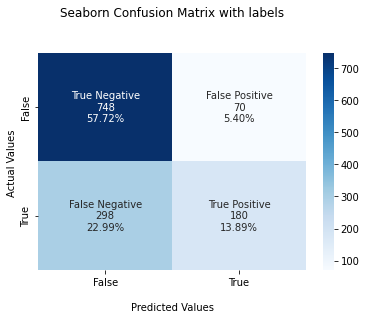

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(X_test)
cf_matrix = confusion_matrix(y_pred, y_test)
group_names = ['True Negative','False Positive','False Negative','True Positive']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix
plt.show()

In [ ]:
print('Best penalty:', model.best_estimator_.get_params()['penalty'])
print('Best C:', model.best_estimator_.get_params()['C'])

Best penalty: l2
Best C: 0.002


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.5003050640634533
Test score:0.4931506849315069


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
model = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='f1')

# Fitting Model & Evaluation
model.fit(X_over_SMOTE, y_over_SMOTE)
y_pred = model.predict(X_test)
eval_classification(model)

Accuracy (Test Set): 0.71
Precision (Test Set): 0.38
Recall (Test Set): 0.72
F1-Score (Test Set): 0.49
AUC (test-proba): 0.77
AUC (train-proba): 0.81


Text(0.5, 1.0, 'feature importance score')

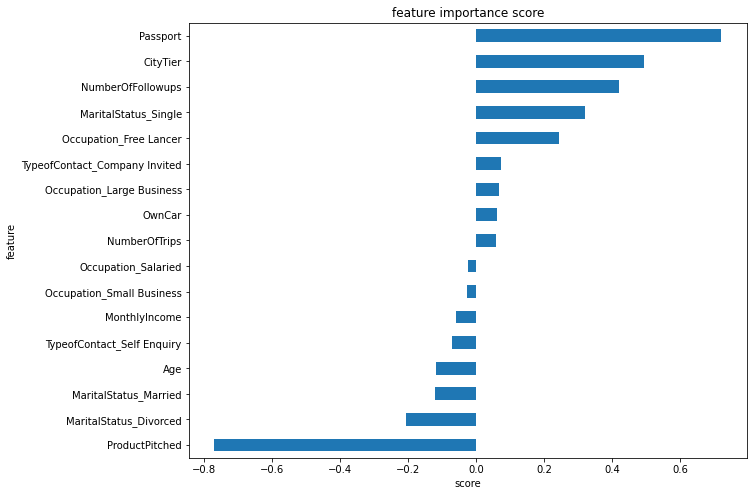

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_over_SMOTE, y_over_SMOTE)
importance = lr.coef_[0]
feat_importances = pd.Series(importance, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

In [ ]:
# memilih 5 best feature dengan koefisien terbesar 
X_best_feature = X_over_SMOTE.drop(columns=['Occupation_Free Lancer','OwnCar', 'TypeofContact_Company Invited', 'NumberOfTrips', 'Occupation_Large Business',
                                           'Occupation_Salaried', 'Occupation_Small Business', 'TypeofContact_Self Enquiry', 'Age', 'MonthlyIncome',
                                           'MaritalStatus_Married', 'MaritalStatus_Divorced'])
X_test_best_feature = X_test.drop(columns=['Occupation_Free Lancer','OwnCar', 'TypeofContact_Company Invited', 'NumberOfTrips', 'Occupation_Large Business',
                                           'Occupation_Salaried', 'Occupation_Small Business', 'TypeofContact_Self Enquiry', 'Age', 'MonthlyIncome',
                                           'MaritalStatus_Married', 'MaritalStatus_Divorced'])

In [ ]:
def eval_classification(model):
    y_pred = model.predict(X_test_best_feature)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_best_feature, y_over_SMOTE)
print('Train score: ' + str(lr.score(X_best_feature, y_over_SMOTE))) #accuracy
print('Test score: ' + str(lr.score(X_test_best_feature, y_test))) #accuracy

Train score: 0.7374335921536576
Test score: 0.7067901234567902


In [ ]:
# mengecek perhitungan evaluation metrics
def eval_classification(model):
    y_pred = model.predict(X_test_best_feature)
    y_pred_train = model.predict(X_best_feature)
    y_pred_proba = model.predict_proba(X_test_best_feature)
    y_pred_proba_train = model.predict_proba(X_best_feature)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_over_SMOTE, y_pred_proba_train[:, 1]))

eval_classification(lr)

Accuracy (Test Set): 0.71
Precision (Test Set): 0.37
Recall (Test Set): 0.74
F1-Score (Test Set): 0.49
AUC (test-proba): 0.77
AUC (train-proba): 0.81


## **Random forest**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

def eval_classification(rf):
    y_pred = rf.predict(X_test)
    y_pred_train = rf.predict(X_over_SMOTE)
    y_pred_proba = rf.predict_proba(X_test)
    y_pred_proba_train = rf.predict_proba(X_over_SMOTE)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_over_SMOTE, y_pred_proba_train[:, 1]))
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_over_SMOTE,y_over_SMOTE)

y_pred = rf.predict(X_test)
eval_classification(rf)

print('Train score: ' + str(rf.score(X_over_SMOTE, y_over_SMOTE))) #accuracy
print('Test score: ' + str(rf.score(X_test, y_test))) #accuracy

Accuracy (Test Set): 0.87
Precision (Test Set): 0.68
Recall (Test Set): 0.57
F1-Score (Test Set): 0.62
AUC (test-proba): 0.88
AUC (train-proba): 1.00
Train score: 1.0
Test score: 0.8657407407407407


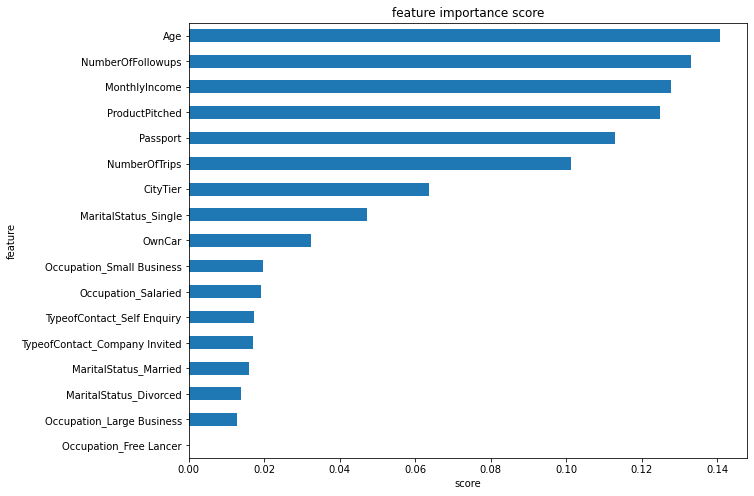

In [ ]:
show_feature_importance(rf)

Bedasarkan Feature Importance Random forest, bisa didapatkan beberapa insight berikut
- Age, Monthly Income, dan pengalaman berpergian sangat mempengaruhi keputusan dalam pengambilan produk.
- Tempat tinggal tidak memiliki pengaruh yang signifikan dalam pengambilan produk
- Status hubungan juga tidak memiliki pengaruh yang signifikan dalam keputusan pengambilan produk
- Status pekerjaan tidak memiliki pengaruh dalam keputusan pengambilan produk
- Pekerja freelancer tidak memiliki minat dalam pengambilan produk

Hyperparameter tuning (belum dirun)

In [ ]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_over_SMOTE)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_over_SMOTE)
    
    #print nilai matriks evaluasinya
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_over_SMOTE, y_pred_proba_train[:, 1]))
    #print("AUC (test-label): %.2f" % roc_auc_score(y_test, y_pred))
    #print("AUC (train-label): %.2f" % roc_auc_score(y_over_SMOTE, y_pred_train))

In [ ]:
# tuning hiperparam di random forest, karena sudah dibagging(RF) masih overfit
# n_estimator: jumlah decision tree/subset yang ditraining diawal by defaul=100
import numpy as np
from sklearn.model_selection import RandomizedSearchCV #menggunakan random search untuk mengurangi komputasi

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 100)], # Jumlah subtree 
                       criterion = ['entropy', 'entropy'],
                       max_depth = [int(x) for x in np.linspace(1, 10, num = 50)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 20)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 10, num = 10)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                      )

# Init
rf = RandomForestClassifier()
rs = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='accuracy', n_iter = 130)
rs.fit(X_over_SMOTE, y_over_SMOTE)

# Predict & Evaluation
eval_classification(rs)

Accuracy (Test Set): 0.86
Precision (Test Set): 0.64
Recall (Test Set): 0.60
F1-Score (Test Set): 0.62
AUC (test-proba): 0.86
AUC (train-proba): 1.00


In [ ]:
# melihat best hyperparameter
show_best_hyperparameter(rs)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 938, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


melihat masing2 parameter dan pengaruhnya terhadap model 

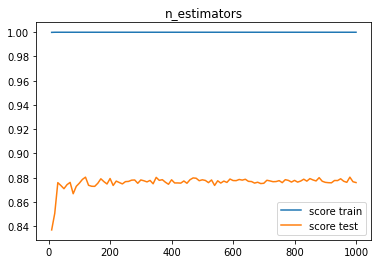

In [ ]:
values = [int(x) for x in np.linspace(start = 10, stop = 100, num = 100)] # n_estimators

# melihat perubahan n_estimator sengefek apa di skor data training dan testing
train_score = []
test_score = []

for x in values:
    model = RandomForestClassifier(n_estimators=x)
    model.fit(X_over_SMOTE, y_over_SMOTE)
    
    #eval test
    y_pred_proba = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, y_pred_proba[:,1])
    test_score.append(auc_test)
    
    #eval train 
    y_pred_proba_train = model.predict_proba(X_over_SMOTE)
    auc_train = roc_auc_score(y_over_SMOTE, y_pred_proba_train[:,1])
    train_score.append(auc_train)
    
    # nanti menampilkan ketika k.nya brapa auc test an trainnya berapa 
    #print('k: '+ str(x) + '; auc(train): '+ str(auc_train) + '; auc(test): ' + str(auc_test))

from matplotlib import pyplot as plt
plt.title('n_estimators')
plt.plot(values, train_score, label='score train')
plt.plot(values, test_score, label='score test')
plt.legend()
plt.show()

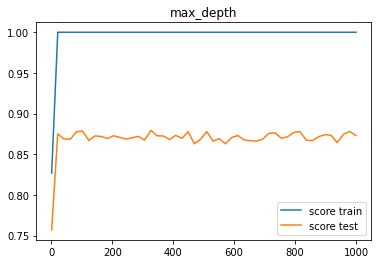

In [ ]:
values = max_depth = [int(x) for x in np.linspace(1, 10, num = 50)] # max_depth

# melihat perubahan max_depth terhadap skor data training dan testing
train_score = []
test_score = []

for x in values:
    model = RandomForestClassifier(n_estimators=50, max_depth=x)
    model.fit(X_over_SMOTE, y_over_SMOTE)
    
    #eval test
    y_pred_proba = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, y_pred_proba[:,1])
    test_score.append(auc_test)
    
    #eval train 
    y_pred_proba_train = model.predict_proba(X_over_SMOTE)
    auc_train = roc_auc_score(y_over_SMOTE, y_pred_proba_train[:,1])
    train_score.append(auc_train)
    
    # nanti menampilkan ketika max_depth.nya brapa auc test an trainnya berapa 
    #print('max_depth: '+ str(x) + '; auc(train): '+ str(auc_train) + '; auc(test): ' + str(auc_test))

from matplotlib import pyplot as plt
plt.title('max_depth')
plt.plot(values, train_score, label='score train')
plt.plot(values, test_score, label='score test')
plt.legend()
plt.show()

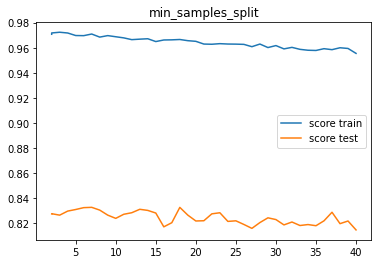

In [ ]:
values = [int(x) for x in np.linspace(start = 2, stop = 10, num = 40)] # min_samples_split

# melihat perubahan min_samples_split terhadap skor data training dan testing
train_score = []
test_score = []

for x in values:
    model = RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_split=x )
    model.fit(X_over_SMOTE, y_over_SMOTE)
    
    #eval test
    y_pred_proba = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, y_pred_proba[:,1])
    test_score.append(auc_test)
    
    #eval train 
    y_pred_proba_train = model.predict_proba(X_over_SMOTE)
    auc_train = roc_auc_score(y_over_SMOTE, y_pred_proba_train[:,1])
    train_score.append(auc_train)
    
    # nanti menampilkan ketika min_samples_split.nya brapa auc test an trainnya berapa 
    #print('min_samples_split: '+ str(x) + '; auc(train): '+ str(auc_train) + '; auc(test): ' + str(auc_test))

from matplotlib import pyplot as plt
plt.title('min_samples_split')
plt.plot(values, train_score, label='score train')
plt.plot(values, test_score, label='score test')
plt.legend()
plt.show()

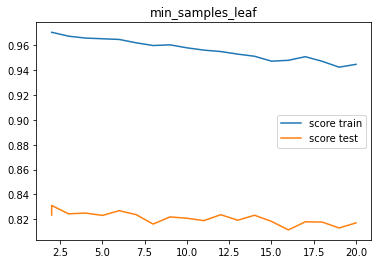

In [ ]:
values = [int(x) for x in np.linspace(start = 2, stop = 10, num = 10)] # min_samples_leaf

# melihat perubahan min_samples_leaf terhadap skor data training dan testing
train_score = []
test_score = []

for x in values:
    model = RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_split=3, min_samples_leaf=x )
    model.fit(X_over_SMOTE, y_over_SMOTE)
    
    #eval test
    y_pred_proba = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, y_pred_proba[:,1])
    test_score.append(auc_test)
    
    #eval train 
    y_pred_proba_train = model.predict_proba(X_over_SMOTE)
    auc_train = roc_auc_score(y_over_SMOTE, y_pred_proba_train[:,1])
    train_score.append(auc_train)
    
    # nanti menampilkan ketika min_samples_leaf.nya brapa auc test an trainnya berapa 
    #print('min_samples_leaf: '+ str(x) + '; auc(train): '+ str(auc_train) + '; auc(test): ' + str(auc_test))

from matplotlib import pyplot as plt
plt.title('min_samples_leaf')
plt.plot(values, train_score, label='score train')
plt.plot(values, test_score, label='score test')
plt.legend()
plt.show()

In [ ]:
model = RandomForestClassifier(random_state=42, 
                                   n_estimators=50, 
                                   max_depth=7, 
                                   min_samples_split=3, 
                                   min_samples_leaf=6).fit(X_over_SMOTE, y_over_SMOTE)
model.score(X_over_SMOTE, y_over_SMOTE), model.score(X_test, y_test)

(0.9143849611769513, 0.8379629629629629)

Hasil akhir gap score antaea data train dan test berkurang

In [ ]:
#show_feature_importance(rf) (lihat fitur importance di atas aja, soalnya harus difitkan dulu)

In [63]:
# best feature
X_best = X_over_SMOTE.drop(columns=['NumberOfTrips', 'CityTier', 'MaritalStatus_Single', 'OwnCar', 'Occupation_Small Business', 'Occupation_Salaried', 
                                    'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry', 'MaritalStatus_Married','MaritalStatus_Divorced', 
                                    'Occupation_Large Business','Occupation_Free Lancer'])
X_test_best = X_test.drop(columns=['NumberOfTrips', 'CityTier', 'MaritalStatus_Single', 'OwnCar', 'Occupation_Small Business', 'Occupation_Salaried', 
                                    'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry', 'MaritalStatus_Married','MaritalStatus_Divorced', 
                                    'Occupation_Large Business','Occupation_Free Lancer'])

In [64]:
from sklearn.ensemble import RandomForestClassifier
def eval_classification(rf):
    y_pred = rf.predict(X_test_best)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_best,y_over_SMOTE)
eval_classification(rf)
print('Train score: ' + str(rf.score(X_best, y_over_SMOTE))) #accuracy
print('Test score: ' + str(rf.score(X_test_best, y_test))) #accuracy

Train score: 0.9957090314671025
Test score: 0.8533950617283951


**Interpretasi** :
Berdasarkan perbandingan kedua model, metode machine learning random forest memiliki lebih tinggi tingkat akurasi sehingga bisa di katakan lebih baik. namun perbedaan ke dua model pada tingkat akurasinya cukup signifikan, jadi bisa dikatakan model RF lebih worth it digunakan. 